In [23]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.sparse import coo_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from PyNetSim import PyNetSim
from random import randint

np.set_printoptions(threshold=sys.maxint)

"""make a checkpoint for time slice

:param step the step of each snapshot
:param row each row of the mataData and it looks like
        node1, node2, linkstart, linkend, connect time, totally connected time

"""


def time_slicer(steps, min_time, max_time):
    # how many snapshot we are going to have
    looper = (max_time - min_time)/steps
    checkpoints = [set([min_time + steps * l, min_time + steps * (l+1)]) for l in range(0, looper)]
    return checkpoints


"""
    Weight cacluation
"""


def link_weight(duration, k):
    return np.exp(duration/k)


"Generate spare martix"
"""
One thing must remember is that node pair in the data has connected, so we don't need
worried about take node pair without connected into account.
"""


def weighted_spare_martix_generator(slice_start, slice_end, mataData):
    row = []
    col = []
    data = []
    k = 160
    for i in mataData:
        duration = (i[3] if i[3] < slice_end else slice_end) - (i[2] if i[2] > slice_start else slice_start)
        #pdb.set_trace()
        # sum weight up if we already have that data
        if i[0] in row and col[row.index(i[0])] == i[1]:
            data[row.index(i[0])] += link_weight(duration, k)
        else:
            row.append(i[0])
            col.append(i[1])
            data.append(link_weight(duration, k))

    m = coo_matrix((data, (row, col)), shape=(42, 42))
    return m


def spare_martix_generator(slice_start, slice_end, mataData):
    row = []
    col = []
    data = []
    k = 160
    for i in mataData:
        if (i[2] >= slice_start and i[3] <= slice_end or
            i[2] <= slice_start and i[2] >= slice_start or
            i[3] <= slice_end and i[3] >= slice_end):
            if i[0] in row and col[row.index(i[0])] == i[1]:
                pass
            else:
                row.append(i[0])
                col.append(i[1])
                data.append(1)
    m = coo_matrix((data, (row, col)), shape=(42, 42))
    return m


""""
    Caculate AUC
"""
def calculate_auc(csrMatrix ,simScore, sample_time = 1000):
    slots = []
    for i in range(0, sample_time):
         slots.append([randint(0,41), randint(0,41)])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return roc_auc_score(samples, score)

""""
    plot roc
"""
def calculate_roc(csrMatrix ,simScore, sample_time = 1000):
    slots = []
    for i in range(0, sample_time):
         slots.append([randint(0,41), randint(0,41)])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return roc_curve(samples, score)

""""
    Caculate pre recall
"""
def calculate_pre_recall(csrMatrix ,simScore, sample_time = 1000):
    slots = []
    for i in range(0, sample_time):
         slots.append([randint(0,41), randint(0,41)])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return precision_recall_curve(samples, score), average_precision_score(samples, score)


"""
    Caculate cosin simiary
"""
def calculate_cosin_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((42,42))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(1, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # cn weight of i
            listi = []
            # cn weight of j
            listj = []
            
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            if len(cnlist) > 0:
                listi = [wadj_martix[i, c] for c in cnlist]
                listj = [wadj_martix[j, c] for c in cnlist]
                cosim = cosine_similarity(listi, listj)
                cosi_matrix[i,j] = cosim[0][0]
    return cosi_matrix

In [24]:
mataData = np.genfromtxt("../MSNs data/INFOCOM06.txt")

# time range of the dataset
t_min = min(mataData[:, 2])
t_max = max(mataData[:, 3])
time_range = t_max - t_min


spare_martix = spare_martix_generator(t_min, t_min+50000, mataData)
weighted_spare_martix = weighted_spare_martix_generator(t_min, t_min+50000, mataData)

In [25]:
# Load martix
csMatrix = spare_martix.tocsr()
csMatrix[csMatrix > 0] = 1
adj_martix = spare_martix.todense()
adj_martix[adj_martix > 0] = 1


wadj_martix = weighted_spare_martix.todense()


NetSim = PyNetSim.PyNetSim()
NetSim.ReadDataFromAdjacencyMatrix(adj_martix)
WNetSim = PyNetSim.PyNetSim()
WNetSim.ReadDataFromAdjacencyMatrix(wadj_martix)

matrix([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
           0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
        [  0.00000000e+000,   0.00000000e+000,   2.35477830e-017,
         

In [27]:
cosins = calculate_cosin_simiary(adj_martix, wadj_martix)

C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.r

C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mike\AppData\Local\conda\conda\envs\experiment_env_2.7\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.r

In [29]:
precision = dict()
recall = dict()
ave_pre = dict()
# katz_pre with unweigthed
katz_martix = NetSim.Katz(lamda=0.1)
temp, ave_pre["katz"]= calculate_pre_recall(csMatrix, katz_martix)
precision["katz"], recall["katz"], _ = temp


# lp_pre with unweigthed
LP_martix = NetSim.LocalPathIndex(lamda=0.1)
temp,  ave_pre["lp"] = calculate_pre_recall(csMatrix, LP_martix)
precision["lp"], recall["lp"],_ = temp


# CN_pre with unweighted
CN_martix = NetSim.CommonNeighbor()
temp,  ave_pre["cn"] = calculate_pre_recall(csMatrix, CN_martix)
precision["cn"], recall["cn"],_ = temp


# AA_pre with unweighted
AA_martix = NetSim.AdamicAdarIndex()
temp,  ave_pre["aa"] = calculate_pre_recall(csMatrix, AA_martix)
precision["aa"], recall["aa"],_ = temp


# wkatz_pre with weighted
Wkatz_martix = WNetSim.Katz(lamda=0.1)
temp,  ave_pre["wkatz"] = calculate_pre_recall(csMatrix, Wkatz_martix)
precision["wkatz"], recall["wkatz"],_ = temp


# wlp_pre with weighted
Wlp_martix = WNetSim.LocalPathIndex(lamda=0.1)
temp,  ave_pre["wlp"] = calculate_pre_recall(csMatrix, Wlp_martix)
precision["wlp"], recall["wlp"],_ = temp

# cosin sim
temp,  ave_pre["cosins"] = calculate_pre_recall(csMatrix, cosins)
precision["cosins"], recall["cosins"],_ = temp


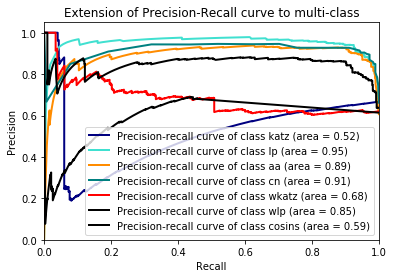

In [30]:
from itertools import cycle

lw = 2

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["katz"], precision["katz"], color="navy", lw=lw,
            label='Precision-recall curve of class katz (area = {0:0.2f})'
                ''.format(ave_pre["katz"]))
plt.plot(recall["lp"], precision["lp"], color="turquoise", lw=lw,
            label='Precision-recall curve of class lp (area = {0:0.2f})'
                ''.format(ave_pre["lp"]))
plt.plot(recall["aa"], precision["aa"], color="darkorange", lw=lw,
            label='Precision-recall curve of class aa (area = {0:0.2f})'
                ''.format(ave_pre["aa"]))
plt.plot(recall["cn"], precision["cn"], color="teal", lw=lw,
            label='Precision-recall curve of class cn (area = {0:0.2f})'
                ''.format(ave_pre["cn"]))
plt.plot(recall["wkatz"], precision["wkatz"], color="r", lw=lw,
            label='Precision-recall curve of class wkatz (area = {0:0.2f})'
                ''.format(ave_pre["wkatz"]))
plt.plot(recall["wlp"], precision["wlp"], color="k", lw=lw,
            label='Precision-recall curve of class wlp (area = {0:0.2f})'
                ''.format(ave_pre["wlp"]))
plt.plot(recall["cosins"], precision["cosins"], color="purple", lw=lw,
            label='Precision-recall curve of class cosins (area = {0:0.2f})'
                ''.format(ave_pre["cosins"]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# katz_roc with unweigthed
katz_martix = NetSim.Katz(lamda=0.1)
fpr["katz"], tpr["katz"], _ = calculate_roc(csMatrix, katz_martix)
roc_auc["katz"] = auc(fpr["katz"], tpr["katz"])

# ip_roc with unweigthed
LP_martix = NetSim.LocalPathIndex(lamda=0.1)
fpr["lp"], tpr["lp"], _ = calculate_roc(csMatrix, LP_martix)
roc_auc["lp"] = auc(fpr["lp"], tpr["lp"])

# CN_roc with unweighted
CN_martix = NetSim.CommonNeighbor()
fpr["cn"], tpr["cn"], _ = calculate_roc(csMatrix, CN_martix)
roc_auc["cn"] = auc(fpr["cn"], tpr["cn"])

# AA_roc with unweighted
AA_martix = NetSim.AdamicAdarIndex()
fpr["aa"], tpr["aa"], _ = calculate_roc(csMatrix, AA_martix)
roc_auc["aa"] = auc(fpr["aa"], tpr["aa"])

# katz_roc with weighted
Wkatz_martix = WNetSim.Katz(lamda=0.1)
fpr["wkatz"], tpr["wkatz"], _ = calculate_roc(csMatrix, Wkatz_martix)
roc_auc["wkatz"] = auc(fpr["wkatz"], tpr["wkatz"])

# lp_roc with weighted
Wlp_martix = WNetSim.LocalPathIndex(lamda=0.1)
fpr["wlp"], tpr["wlp"], _ = calculate_roc(csMatrix, Wlp_martix)
roc_auc["wlp"] = auc(fpr["wlp"], tpr["wlp"])

# cosins
fpr["cosins"], tpr["cosins"], _ = calculate_roc(csMatrix, Wlp_martix)
roc_auc["cosins"] = auc(fpr["cosins"], tpr["cosins"])

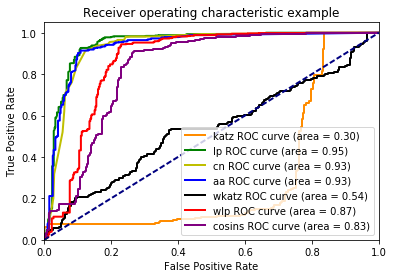

In [32]:
# plot roc
plt.figure()
lw = 2
plt.plot(fpr["katz"], tpr["katz"], color='darkorange',
         lw=lw, label='katz ROC curve (area = %0.2f)' % roc_auc["katz"])
plt.plot(fpr["lp"], tpr["lp"], color='g',
         lw=lw, label='lp ROC curve (area = %0.2f)' % roc_auc["lp"])
plt.plot(fpr["cn"], tpr["cn"], color='y',
         lw=lw, label='cn ROC curve (area = %0.2f)' % roc_auc["cn"])
plt.plot(fpr["aa"], tpr["aa"], color='b',
         lw=lw, label='aa ROC curve (area = %0.2f)' % roc_auc["aa"])
plt.plot(fpr["wkatz"], tpr["wkatz"], color='k',
         lw=lw, label='wkatz ROC curve (area = %0.2f)' % roc_auc["wkatz"])
plt.plot(fpr["wlp"], tpr["wlp"], color='r',
         lw=lw, label='wlp ROC curve (area = %0.2f)' % roc_auc["wlp"])

plt.plot(fpr["cosins"], tpr["cosins"], color='purple',
         lw=lw, label='cosins ROC curve (area = %0.2f)' % roc_auc["cosins"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()